In [5]:
spark.stop()

 This Spark session is configured to use Apache Iceberg with a REST catalog and MinIO as S3-compatible storage.
It defines a custom catalog named "iceberg_catalog", connects it to the Iceberg REST service,
and sets the warehouse location where all Iceberg table data will be stored.
 MinIO credentials and endpoint are provided to allow Spark to read and write data to object storage.
 Before running this notebook, make sure to create a bucket named "warehouse" in the MinIO web interface.
This setup enables full Iceberg functionality such as table creation, inserts, snapshots, and optimizations.

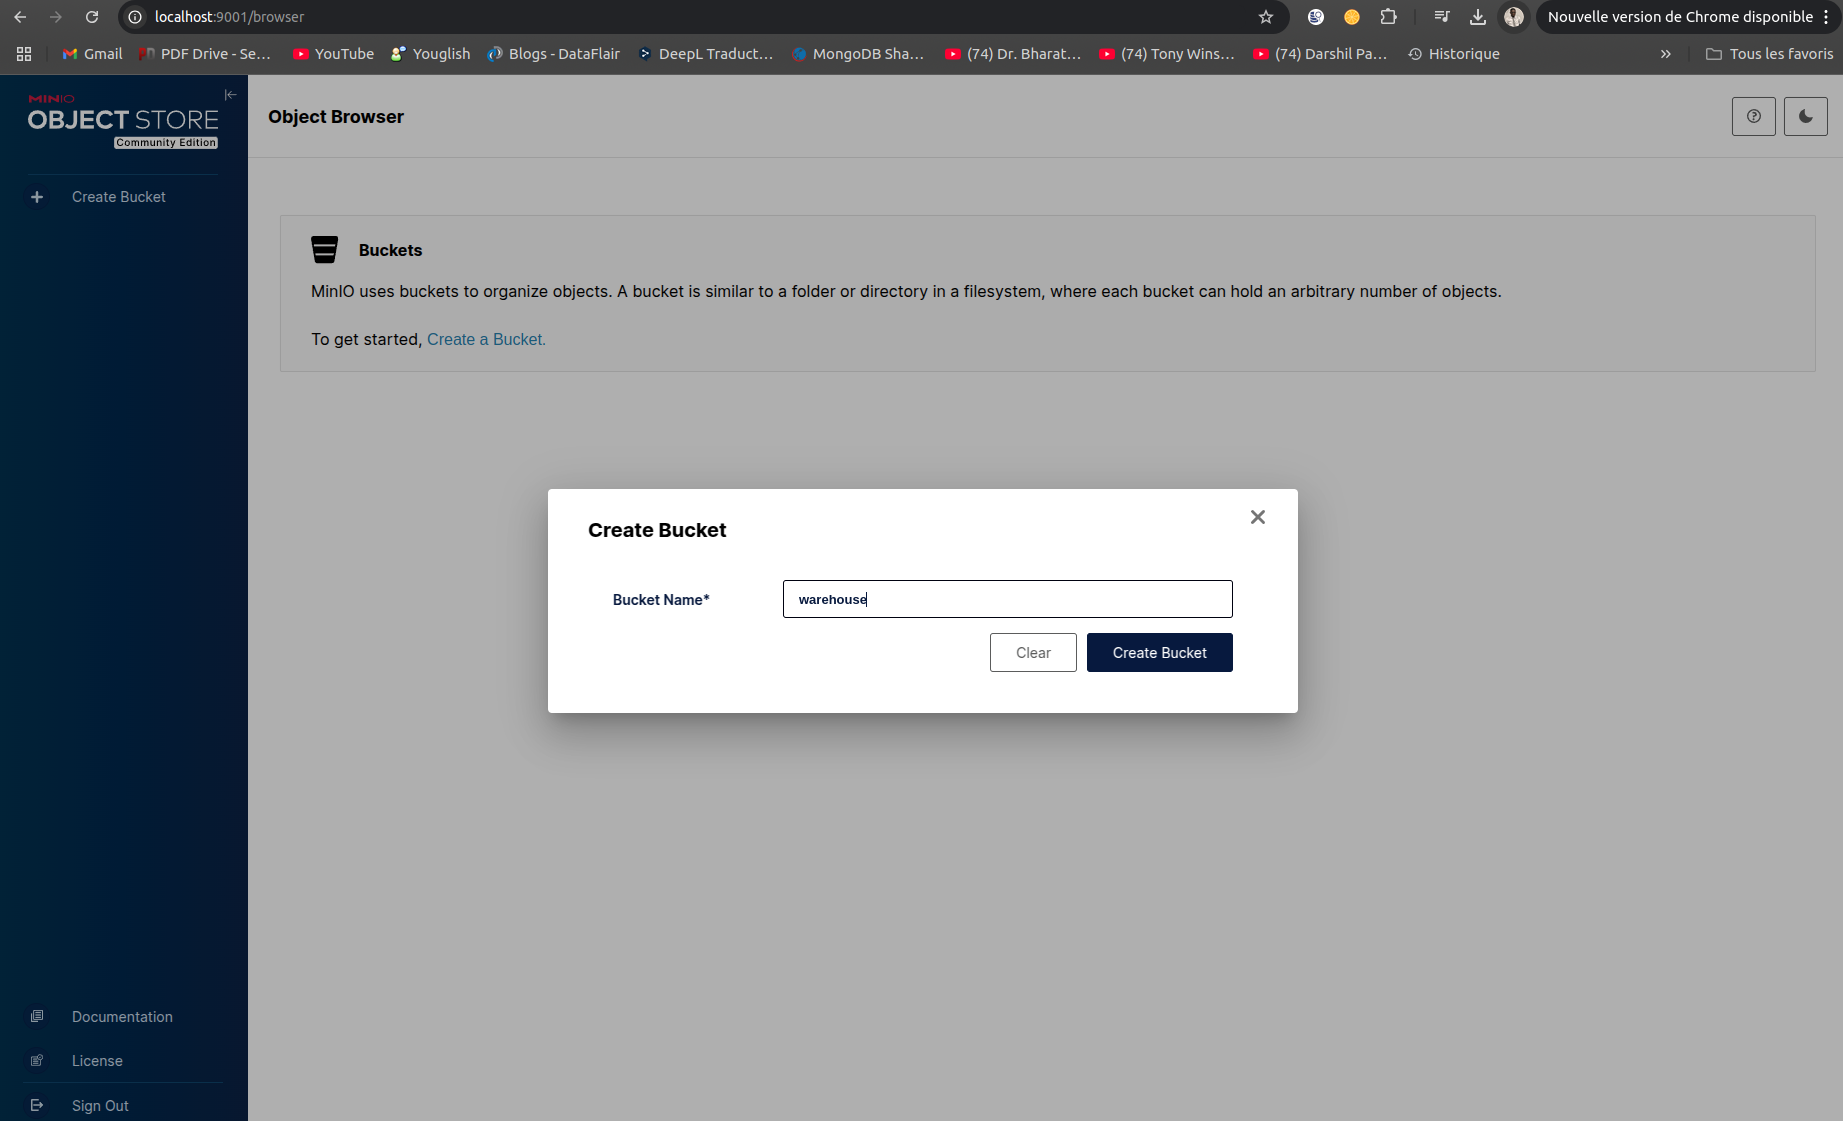


# SPARK CONFIGURATION

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("IcebergSparkWithMinIO") \
    .config("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions") \
    .config("spark.sql.catalog.iceberg_catalog", "org.apache.iceberg.spark.SparkCatalog") \
    .config("spark.sql.catalog.iceberg_catalog.type", "rest") \
    .config("spark.sql.catalog.iceberg_catalog.uri", "http://iceberg-rest:8181") \
    .config("spark.sql.catalog.iceberg_catalog.warehouse", "s3://warehouse/") \
    .config("spark.sql.catalog.iceberg_catalog.io-impl", "org.apache.iceberg.aws.s3.S3FileIO") \
    .config("spark.sql.catalog.iceberg_catalog.s3.endpoint", "http://minio:9000") \
    .config("spark.sql.catalog.iceberg_catalog.s3.access-key-id", "admin") \
    .config("spark.sql.catalog.iceberg_catalog.s3.secret-access-key", "password") \
    .config("spark.sql.catalog.iceberg_catalog.s3.path-style-access", "true") \
    .getOrCreate()

25/12/05 22:21:59 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
spark.sql("SHOW DATABASES IN iceberg_catalog").show()

+---------+
|namespace|
+---------+
|  default|
+---------+



In [3]:
spark.conf.get("spark.sql.catalog.iceberg_catalog")

'org.apache.iceberg.spark.SparkCatalog'

In [4]:
spark.conf.get("spark.sql.catalog.iceberg_catalog.warehouse")

's3://warehouse/'

In [10]:
spark.conf.get("spark.sql.catalog.iceberg_catalog.type")

'rest'

In [13]:
spark.conf.get("spark.sql.catalog.iceberg_catalog.uri")

'http://iceberg-rest:8181'

It creates the default namespace in the iceberg_catalog if it doesn’t already exist

# CREATE NAMESPACE

In [15]:
spark.sql("""
    CREATE NAMESPACE IF NOT EXISTS iceberg_catalog.default
""")


DataFrame[]

# CREATE A TABLE 

Let's create a table named : my_table

In [16]:
spark.sql("""
    CREATE TABLE iceberg_catalog.default.my_table (
        id BIGINT,
        name STRING
    ) USING iceberg
""")

DataFrame[]

# TABLE'S FILES ON MINIO

This is the result in MinIO under the directory: warehouse/default/my_table.
We only see a metadata repository because no data has been inserted yet — only the table’s metadata has been created.

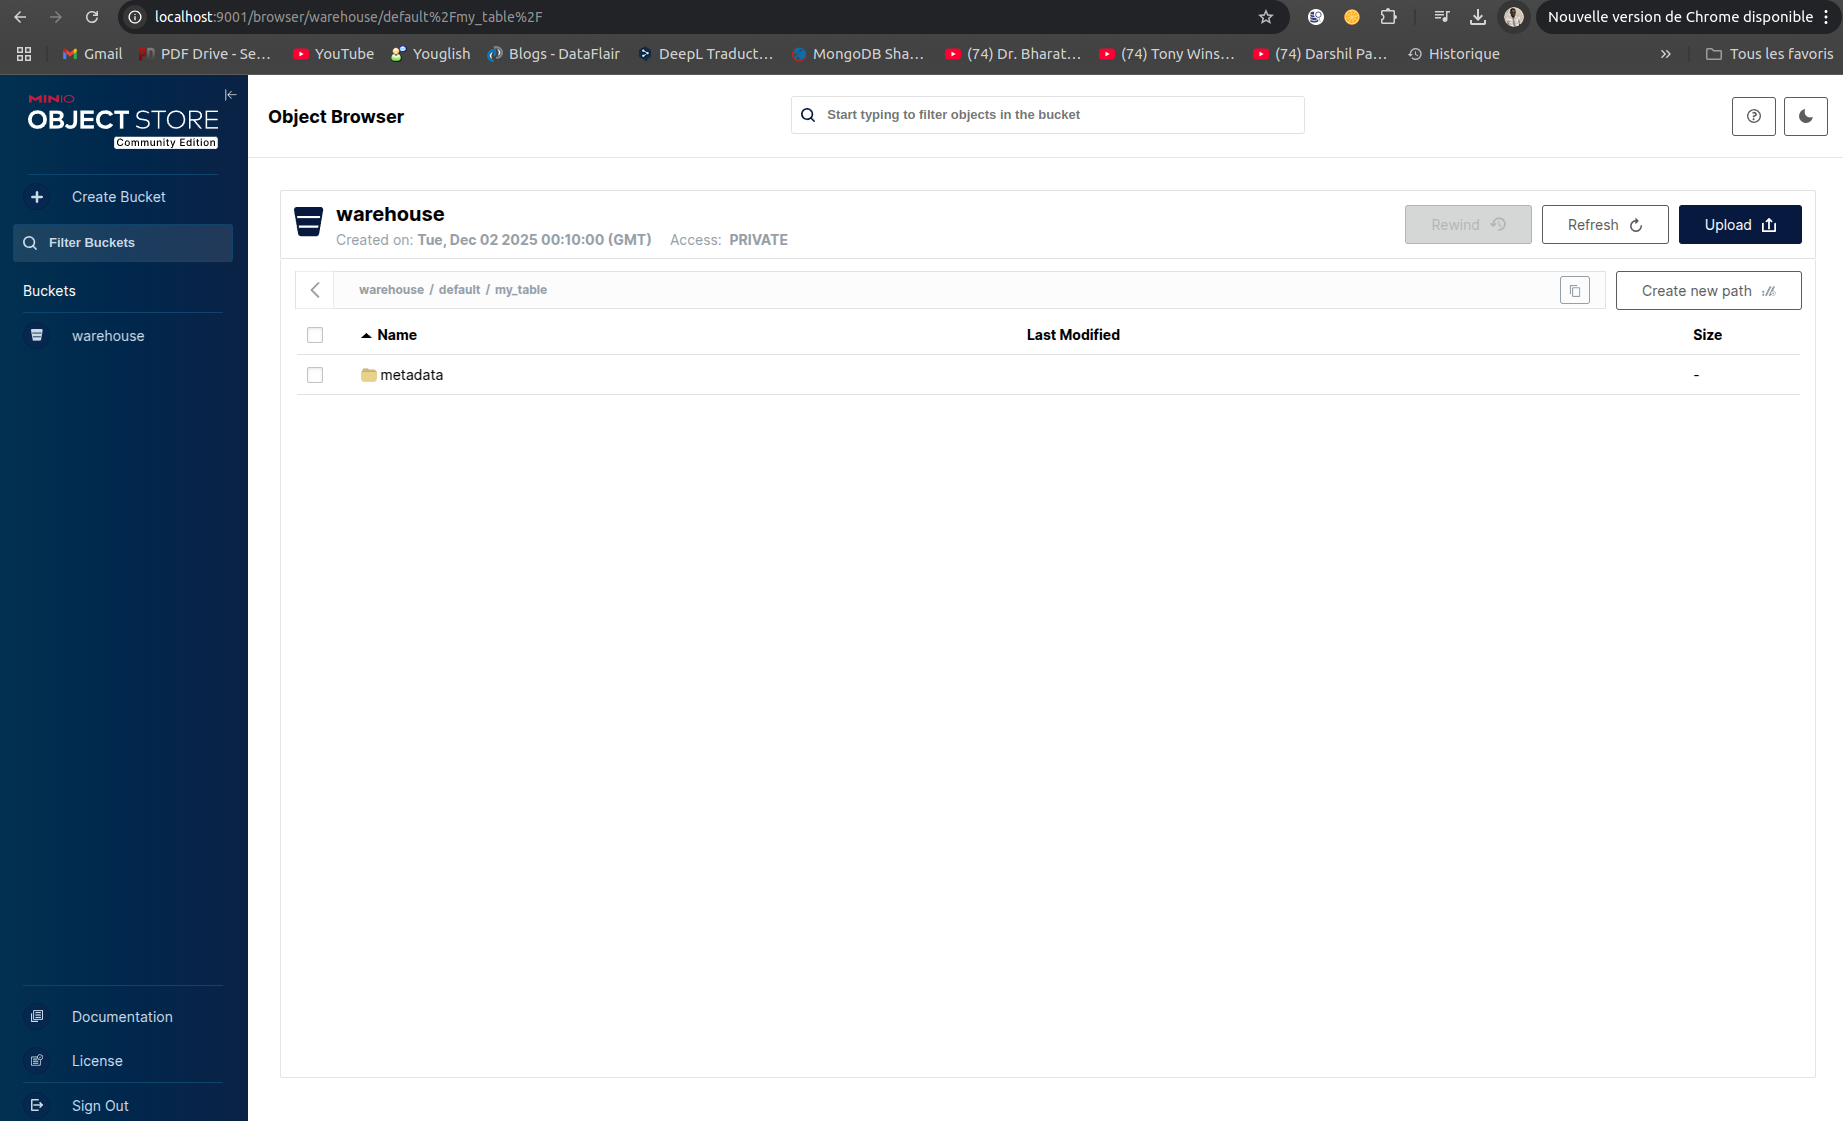

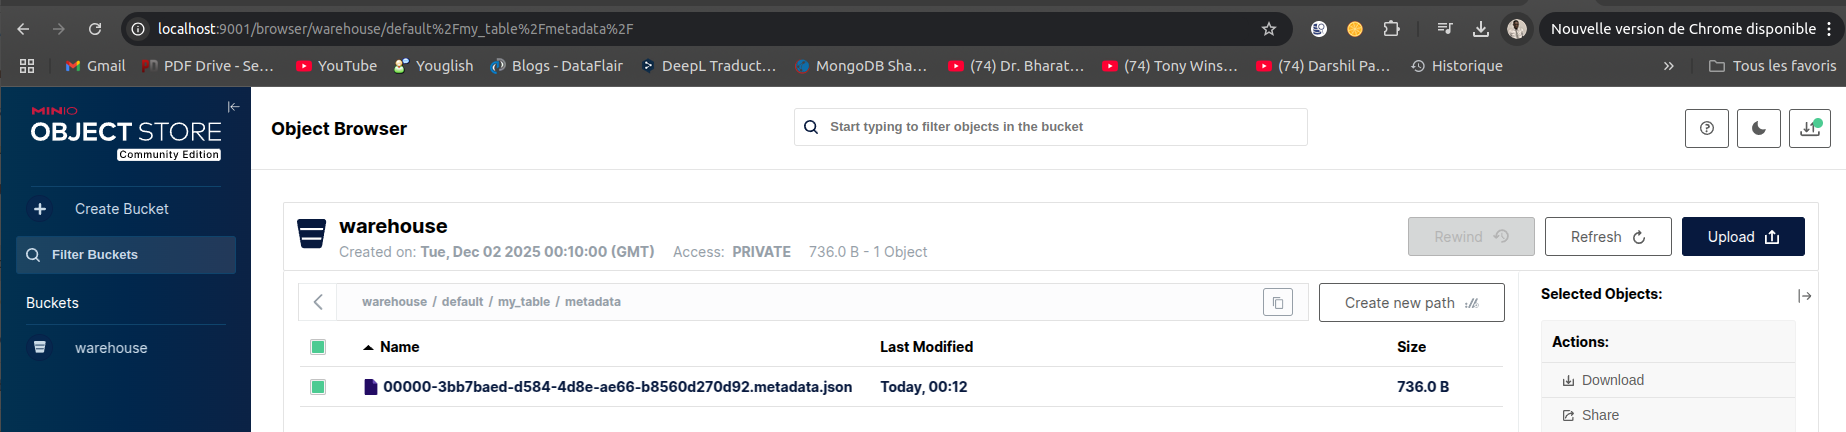

Here is the content of metadata.json. As you can see, it stores all the metadata information about the table.

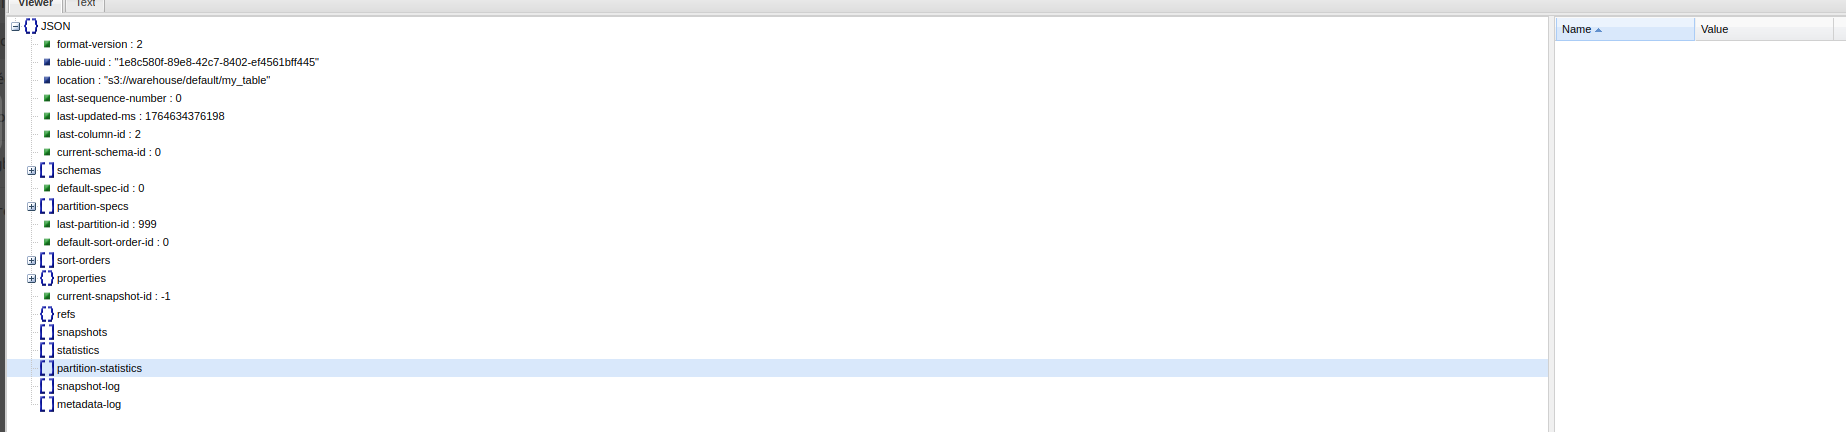

In [6]:
spark.sql("""
    SELECT * 
    FROM iceberg_catalog.default.my_table.history
    ORDER BY made_current_at DESC
    LIMIT 2
""").show(truncate=False)


+-----------------------+-------------------+---------+-------------------+
|made_current_at        |snapshot_id        |parent_id|is_current_ancestor|
+-----------------------+-------------------+---------+-------------------+
|2025-12-02 00:21:40.832|7127313601007651275|NULL     |true               |
+-----------------------+-------------------+---------+-------------------+



# INSERT SOME DATA

In [19]:
spark.sql("INSERT INTO iceberg_catalog.default.my_table VALUES (1, 'Alice'), (2, 'Bob')")
df = spark.sql("SELECT * FROM iceberg_catalog.default.my_table")
df.show()

+---+-----+
| id| name|
+---+-----+
|  1|Alice|
|  2|  Bob|
+---+-----+



# MINIO VIEW ABOUT THE NEW INSERT DATA 

Now we have data in the directoy : warehouse/default/my_table/data




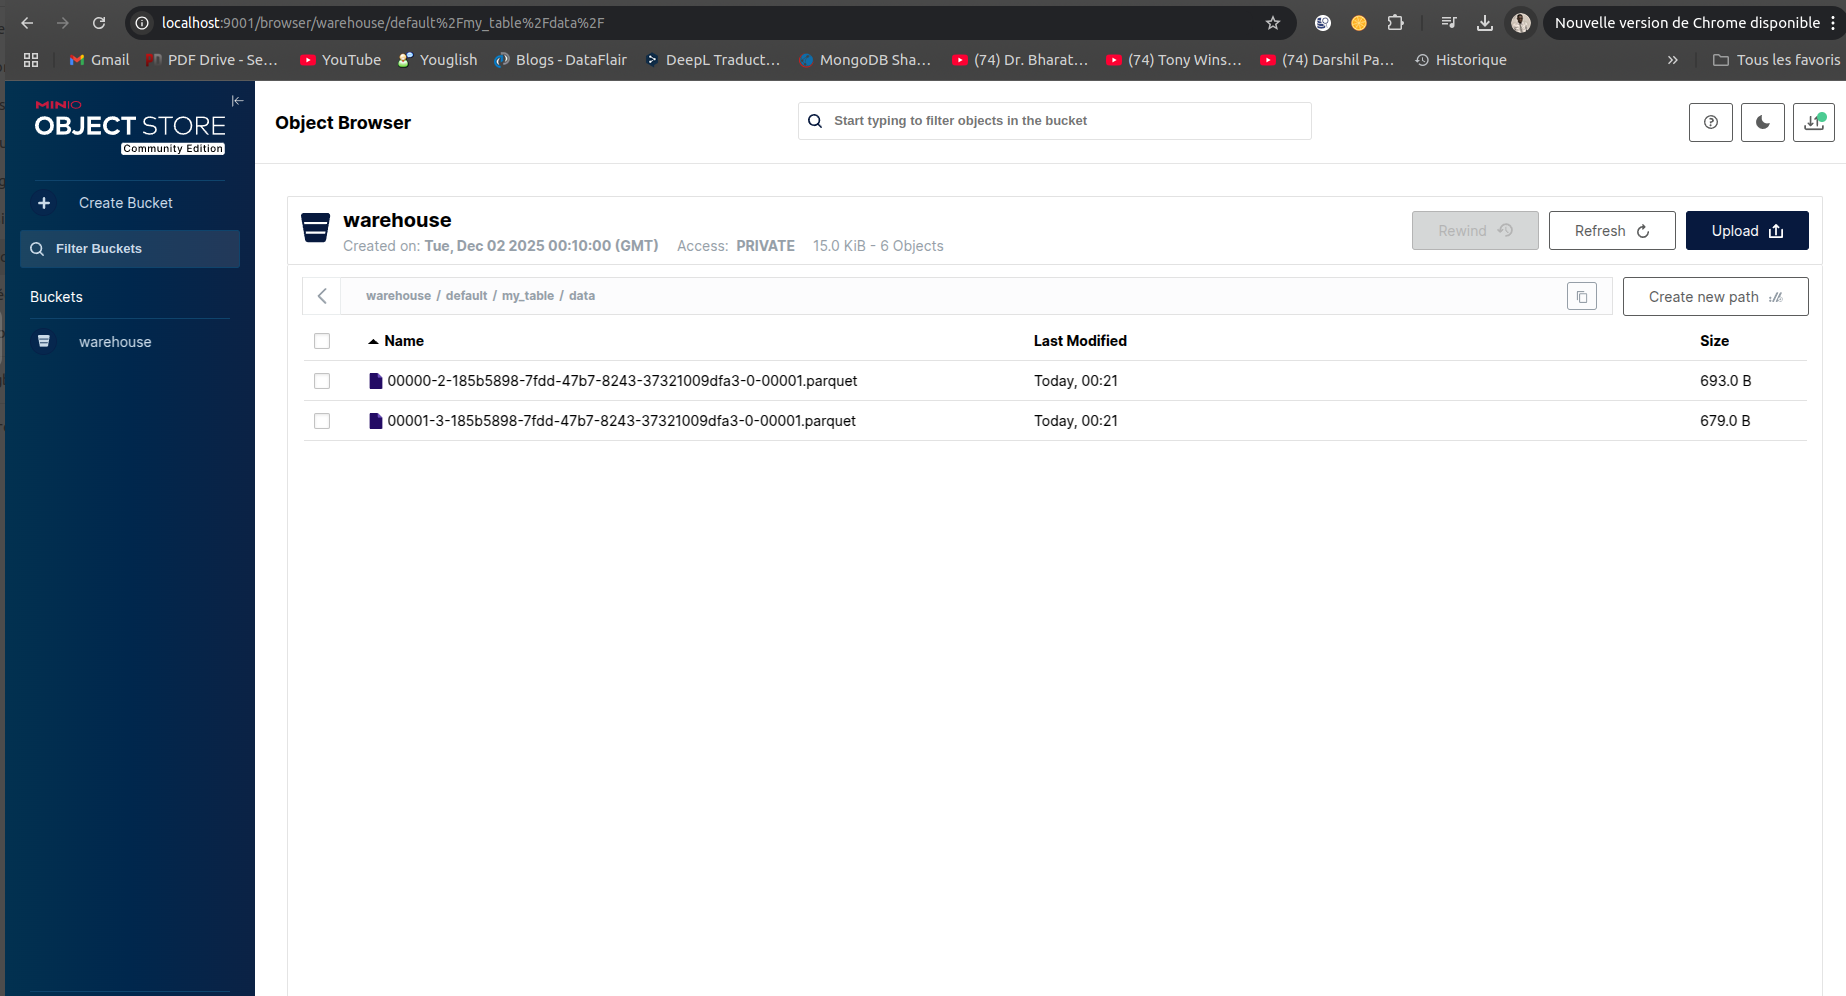


We have four files:

00001-c04fed86-8176-4931-9084-5cc2f898532a.metadata.json is the new metadata file that the Iceberg table now points to.

snap-7127313601007651275-1-a71b3fd1-d8c2-4547-b676-8ddc56c2be46.avro represents the snapshot.

a71b3fd1-d8c2-4547-b676-8ddc56c2be46-m0.avro represents both the manifest file and the manifest list. Since we inserted only a few records, Iceberg optimized them by combining both into a single file. Normally, there would be two separate .avro files: one for the manifest list and another for the manifest files.






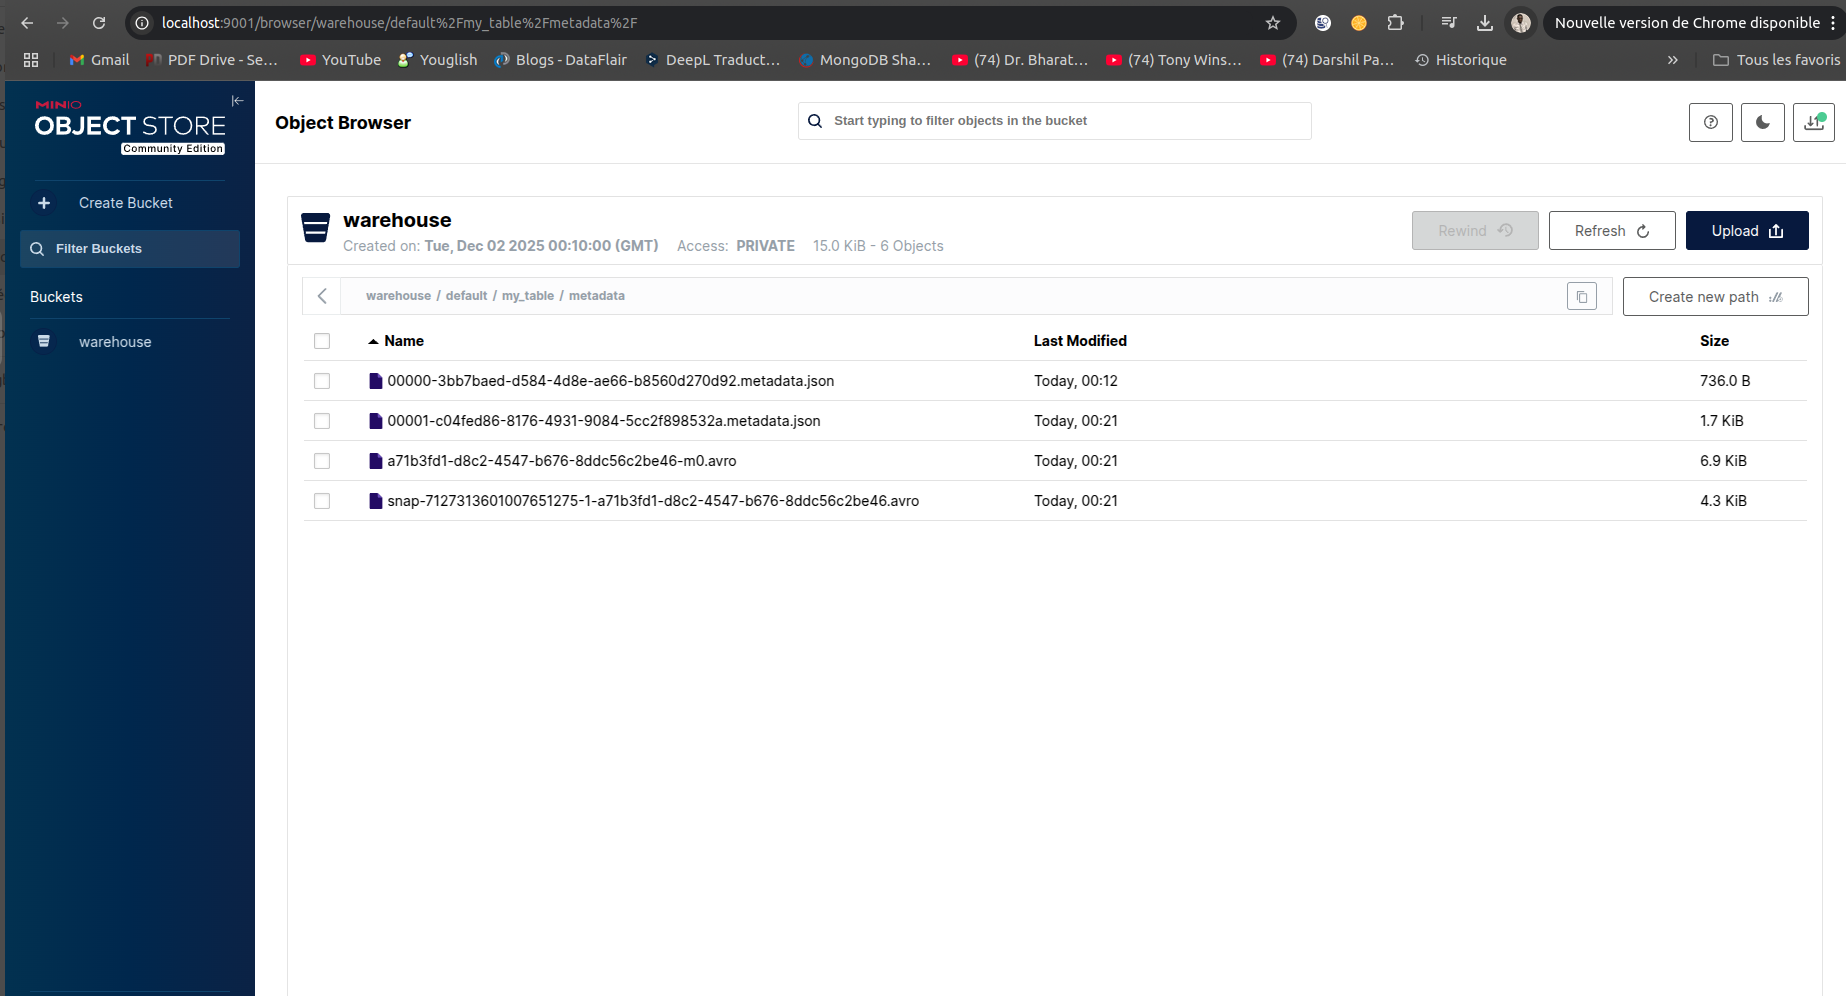

In [7]:
df = spark.sql("SELECT * FROM iceberg_catalog.default.my_table")
df.show()

+---+-----+
| id| name|
+---+-----+
|  1|Alice|
|  2|  Bob|
+---+-----+



let's check the snapshot

In [8]:
spark.sql("SELECT * FROM iceberg_catalog.default.my_table.snapshots").show()

+--------------------+-------------------+---------+---------+--------------------+--------------------+
|        committed_at|        snapshot_id|parent_id|operation|       manifest_list|             summary|
+--------------------+-------------------+---------+---------+--------------------+--------------------+
|2025-12-02 00:21:...|7127313601007651275|     NULL|   append|s3://warehouse/de...|{spark.app.id -> ...|
+--------------------+-------------------+---------+---------+--------------------+--------------------+



In [26]:
spark.sql("""
    SELECT * 
    FROM iceberg_catalog.default.my_table.history
    ORDER BY made_current_at DESC
    LIMIT 1
""").show(truncate=False)


+-----------------------+-------------------+---------+-------------------+
|made_current_at        |snapshot_id        |parent_id|is_current_ancestor|
+-----------------------+-------------------+---------+-------------------+
|2025-12-02 00:21:40.832|7127313601007651275|NULL     |true               |
+-----------------------+-------------------+---------+-------------------+



let's check the inside of the snapshot id and the manifest file

## snapshot File
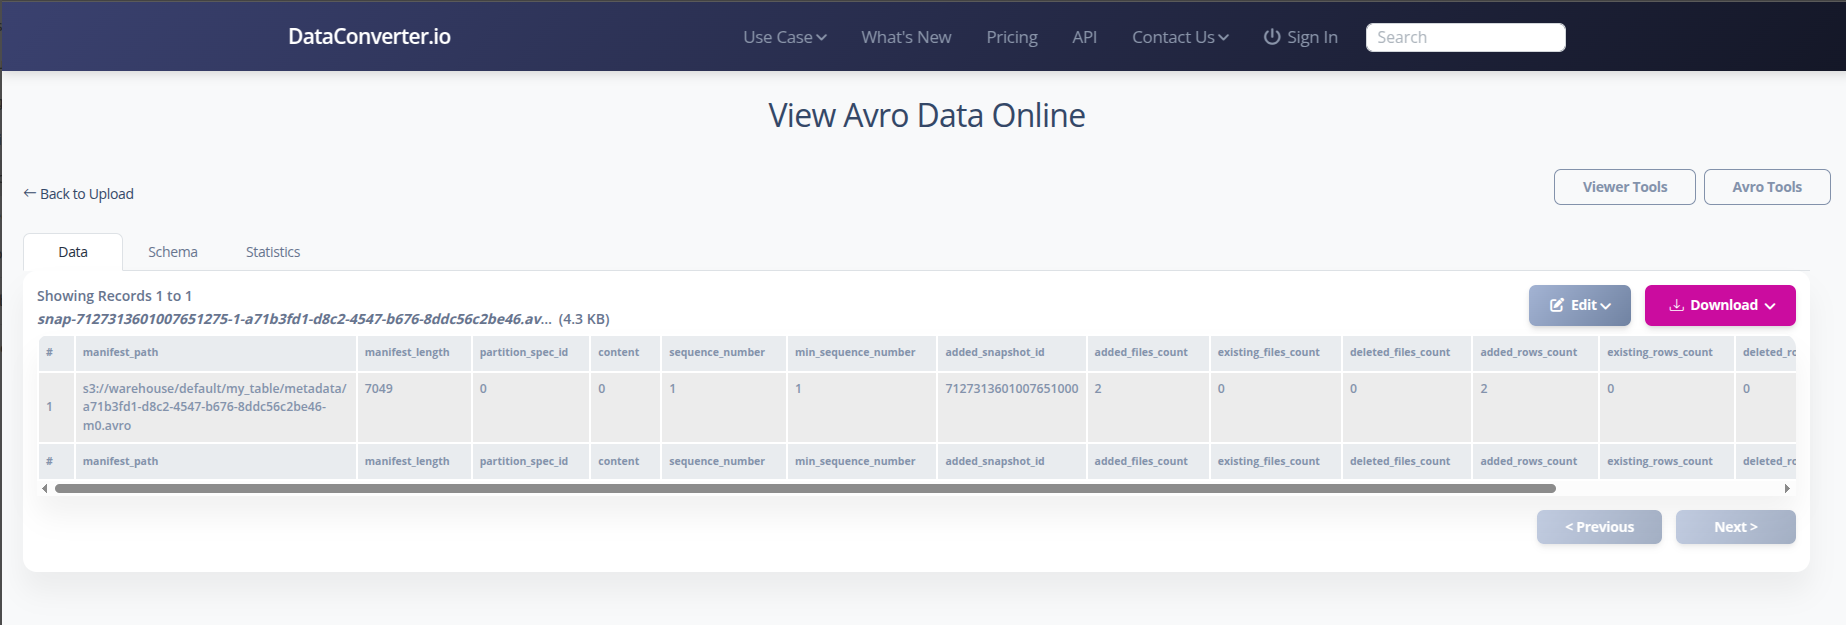
In the snapshot file, we can see the number of data files associated with this snapshot, as well as a reference to the manifest file.
The manifest file then contains the paths to the actual data files that store the snapshot’s data.
## Manifest File

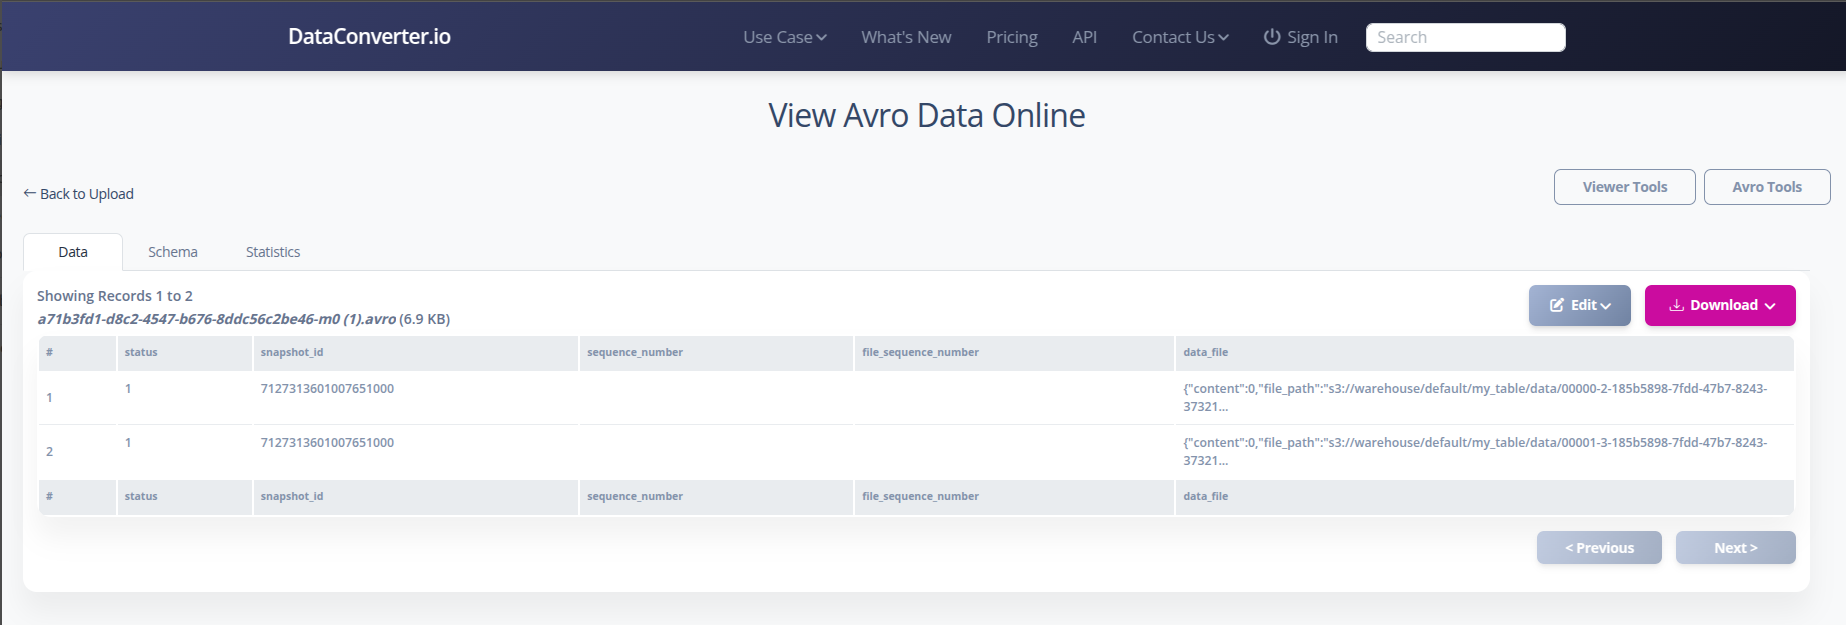

The manifest file stores the ID of the snapshot it belongs to and the paths to the data files.

# UPDATING THE TABLE 

In [9]:
spark.sql('''UPDATE iceberg_catalog.default.my_table 
SET name = 'David'
WHERE id = 1''')

DataFrame[]

In [10]:
spark.sql("SELECT * FROM iceberg_catalog.default.my_table.snapshots").show()

+--------------------+-------------------+-------------------+---------+--------------------+--------------------+
|        committed_at|        snapshot_id|          parent_id|operation|       manifest_list|             summary|
+--------------------+-------------------+-------------------+---------+--------------------+--------------------+
|2025-12-02 00:21:...|7127313601007651275|               NULL|   append|s3://warehouse/de...|{spark.app.id -> ...|
|2025-12-05 22:53:...|6323587189617479683|7127313601007651275|overwrite|s3://warehouse/de...|{spark.app.id -> ...|
+--------------------+-------------------+-------------------+---------+--------------------+--------------------+



In [13]:
latest_snapshot_id = spark.sql("SELECT snapshot_id FROM iceberg_catalog.default.my_table.snapshots ORDER BY committed_at DESC LIMIT 1").collect()[0][0]
print(latest_snapshot_id)

6323587189617479683


After updating the data, we now have:

- A new snapshot: `snap-7127313601007651275-1-a71b3fd1-d8c2-4547-b676-8ddc56c2be46.avro`
- A new metadata file: `00002-e4654012-d9fd-405e-af75-901c70c8e1ba.metadata.json`
- Two new manifest files:  
  - `680e5788-2871-4fbe-83c4-6eee8bb97417-m0.avro`  
  - `680e5788-2871-4fbe-83c4-6eee8bb97417-m1.avro`

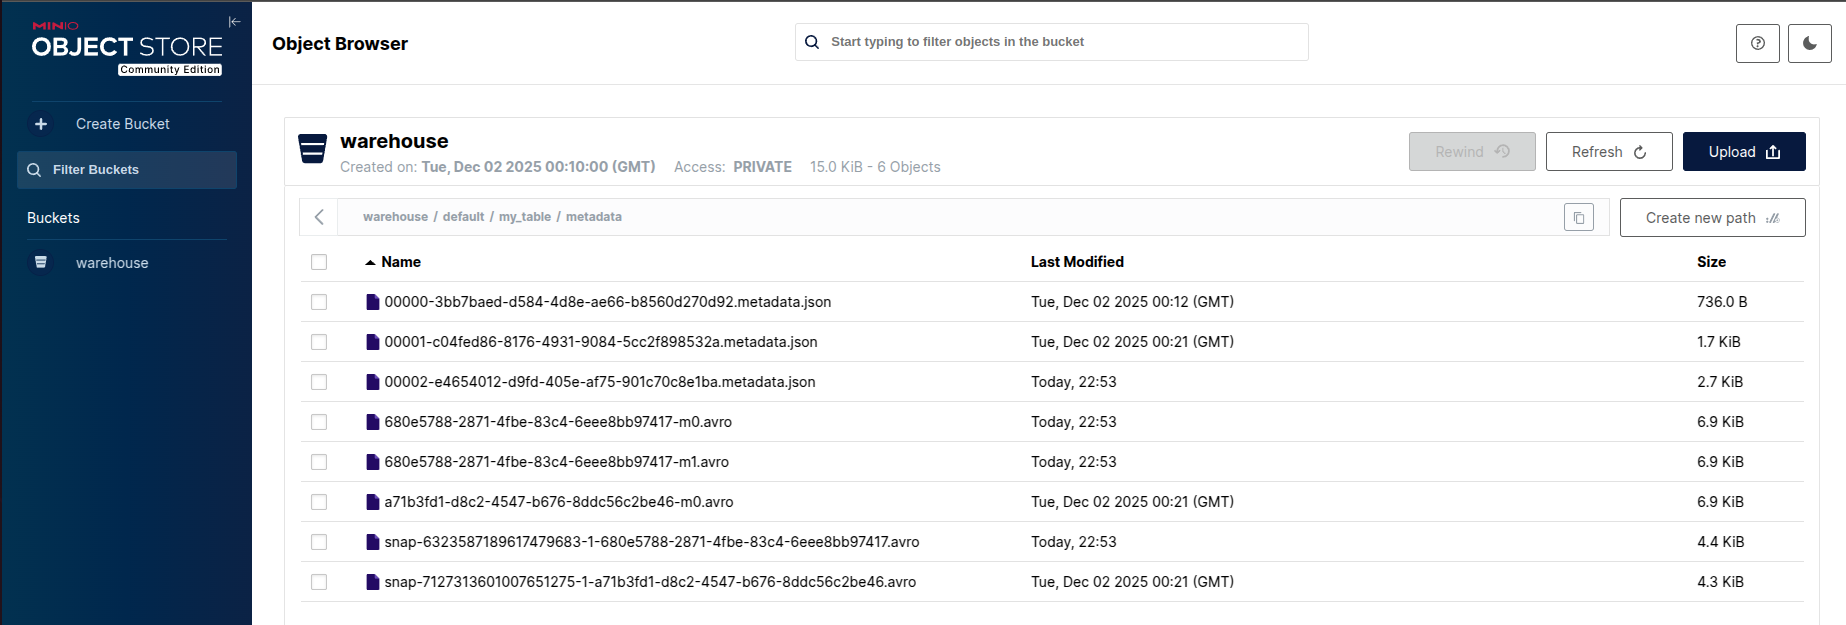

## Snapshot

We can see that the snapshot points to two manifest files, which together make up the manifest list for this snapshot.

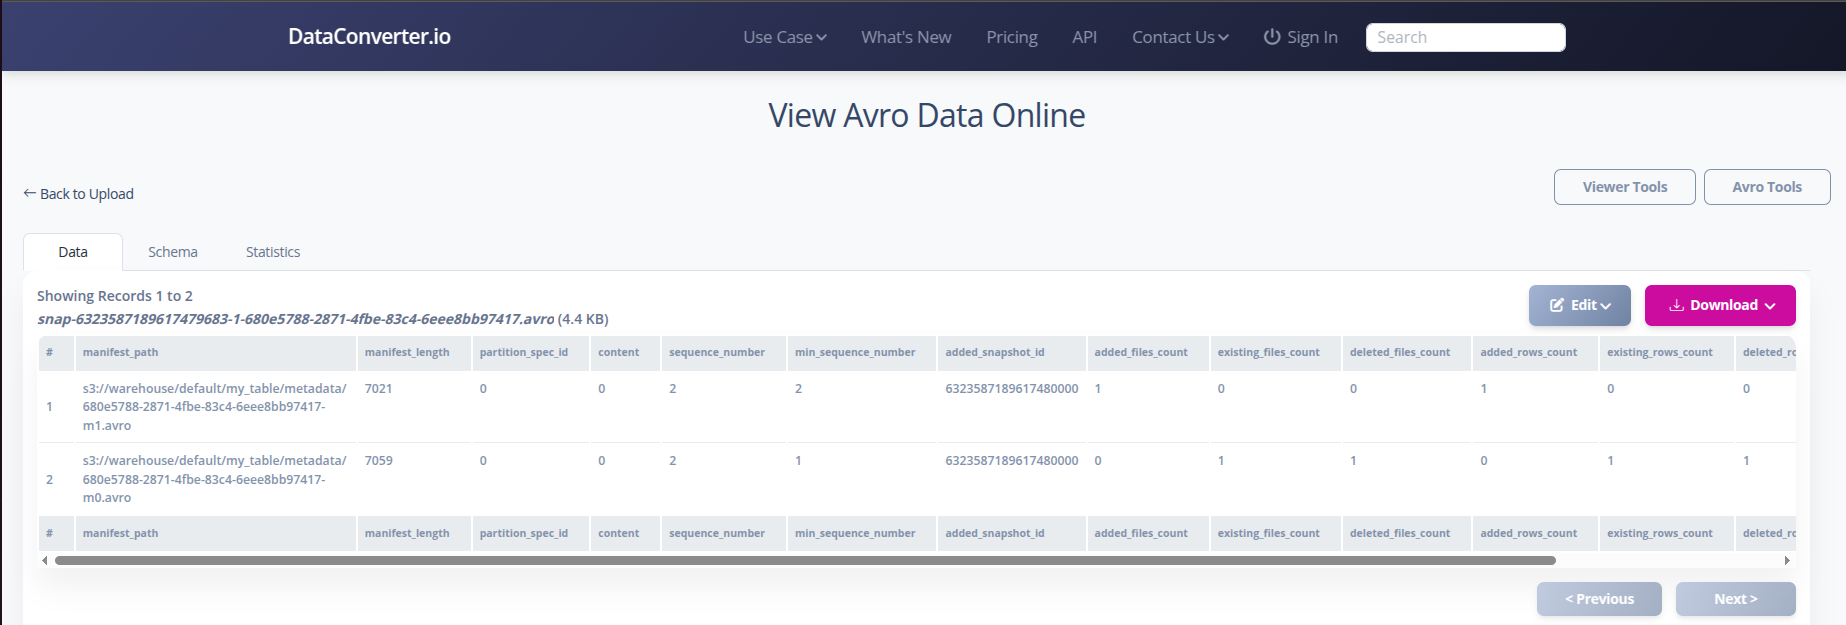

## Data File

Finally, in the data files directory, we can see a new data file: 00000-7-88c42460-4cb9-4844-b3f4-93f30730be90-0-00001.parquet

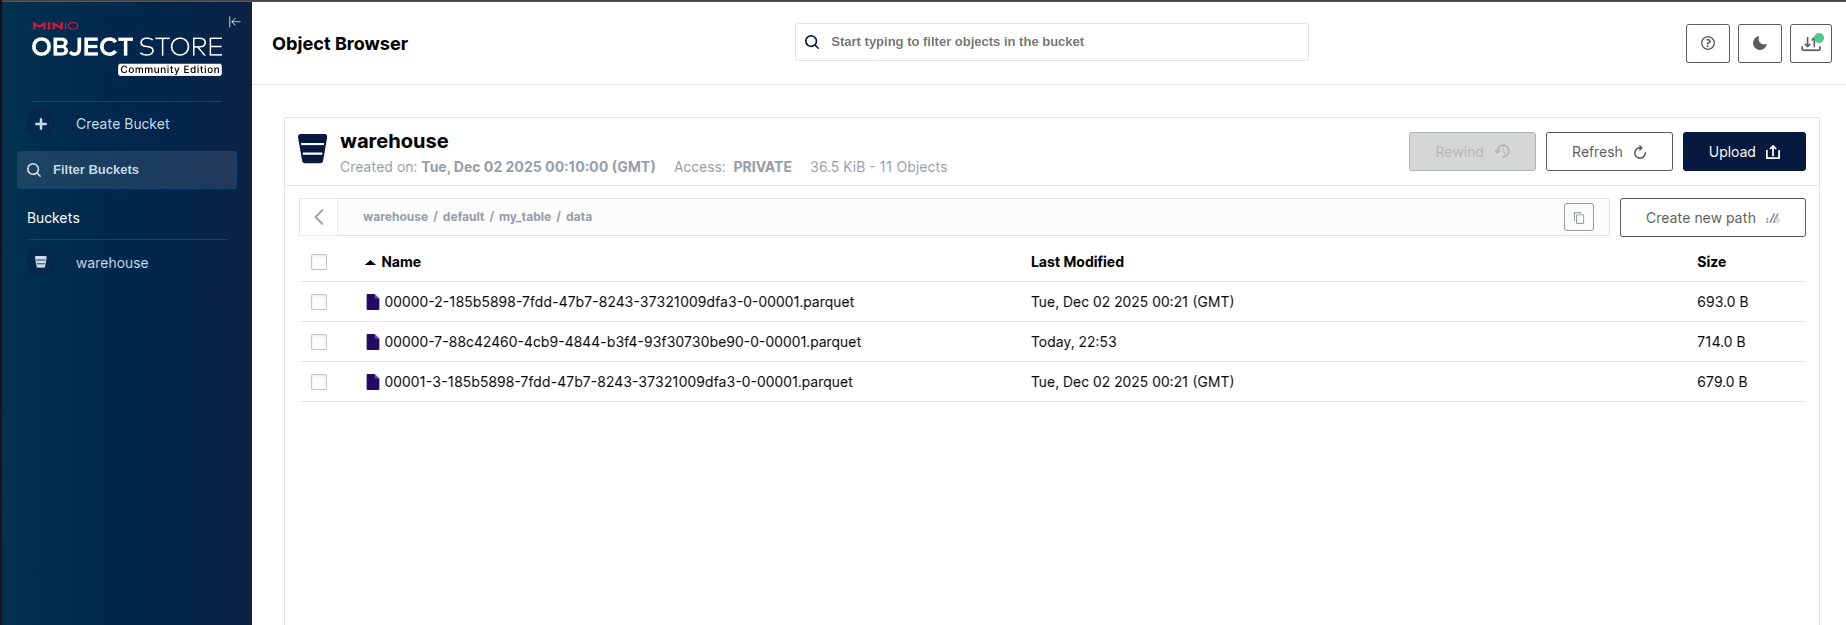


In [18]:
spark.sql(f'''SELECT * FROM iceberg_catalog.default.my_table.manifests WHERE added_snapshot_id = {latest_snapshot_id}''').show()

+-------+--------------------+------+-----------------+-------------------+----------------------+-------------------------+------------------------+------------------------+---------------------------+--------------------------+-------------------+
|content|                path|length|partition_spec_id|  added_snapshot_id|added_data_files_count|existing_data_files_count|deleted_data_files_count|added_delete_files_count|existing_delete_files_count|deleted_delete_files_count|partition_summaries|
+-------+--------------------+------+-----------------+-------------------+----------------------+-------------------------+------------------------+------------------------+---------------------------+--------------------------+-------------------+
|      0|s3://warehouse/de...|  7021|                0|6323587189617479683|                     1|                        0|                       0|                       0|                          0|                         0|                 []|
